_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Project 3: Single-cell data analysis.

In [74]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##
import seaborn as sns

import time
import pickle

# import memory_profiler

# %load_ext memory_profiler

from pathlib import Path

In [75]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [76]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [77]:
plt.style.use(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/matplotlib_style.txt"
)

In [78]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [79]:
# META DATA

meta = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_meta_data.csv",
    sep="\t",
)

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [80]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

In [81]:
meta.head

<bound method NDFrame.head of       Number               Cell             Slice        Date    Sample  \
0          1  20171204_sample_2  20171204_slice_2  2017-12-04  sample 2   
1          2  20171204_sample_4  20171204_slice_4  2017-12-04  sample 4   
2          3  20171204_sample_5  20171204_slice_5  2017-12-04  sample 5   
3          4  20171204_sample_6  20171204_slice_6  2017-12-04  sample 6   
4          5  20171207_sample_1  20171207_slice_1  2017-12-07  sample 1   
...      ...                ...               ...         ...       ...   
1324    1325  20200225_sample_2  20200225_slice_2  2020-02-25  Sample 2   
1325    1326  20200225_sample_5  20200225_slice_5  2020-02-25  Sample 5   
1326    1327  20200316_sample_1  20200316_slice_1  2020-03-16  Sample 1   
1327    1328  20200316_sample_2  20200316_slice_2  2020-03-16  Sample 2   
1328    1329  20200316_sample_3  20200316_slice_3  2020-03-16  Sample 3   

            Mouse Mouse date of birth  Mouse age Mouse gender  \
0   

### "Ground truth labels"

In [82]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [83]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]

In [84]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [85]:
pickle_in = open(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/dict_rna_type_colors.pkl",
    "rb",
)
dict_rna_type_colors = pickle.load(pickle_in)

In [86]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [87]:
# READ COUNTS
data_exons = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [88]:
# GENE LENGTH

data = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/gene_lengths.txt"
)
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

### Electrophysiological features

In [89]:
# EPHYS DATA

ephysData = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_ephys_features.csv"
)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [90]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [91]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

**1) Inspect the data by computing key statistics**

as from referenced paper: “QC covariates should be considered jointly … and thresholds should be set as permissive as possible to avoid filtering out viable cell populations unintentionally.”

Per cell statistics:
- Total counts per cell: The sum of all gene counts in a cell (cell "library size"/sequencing depth).
- Number of expressed genes per cell: How many genes have nonzero counts in each cell (cell “complexity”).
- Fraction of mitochondrial counts per cell (optional, but standard in scRNA-seq, if mitochondrial genes are annotated): High values can indicate damaged cells.

Per-gene statistics:
- Mean count per gene: Average expression of each gene across all cells.
- Variance per gene: Variability of each gene’s expression across all cells.
- Mean-variance relationship: Plot mean expression vs variance for genes—a key plot in single-cell to spot technical noise and variability.

Filter out genes that are not expressed in at least a minimal number of cells 
Revisit QC after downstream analysis—if clustering doesn’t make sense, consider redoing or adjusting QC.


Excluded cells if:
They failed experimenter-defined QC (“exclusion reasons”)
They had extremely low RNA yield
They had outlier total RNA counts or numbers of genes
They failed assignment confidence (if RNA mapping to reference types was too uncertain; e.g. max correlation to reference clusters < 0.4)
They were likely contaminated (e.g., non-neuronal identity or ambiguous cluster mapping)
(For ephys) Cells with ephys features that were undefined, redundant, or highly skewed were also excluded



Cells flagged for exclusion by experimenter: 7


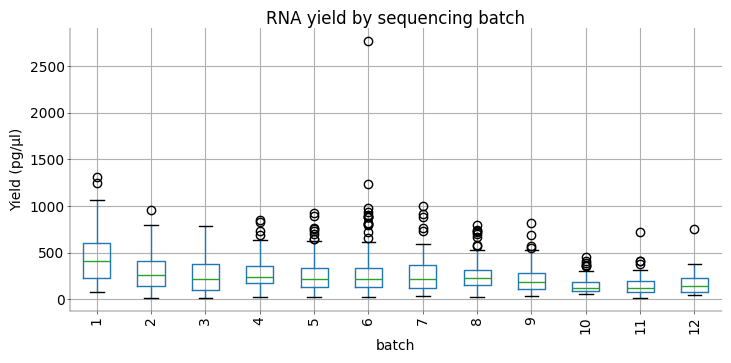

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2349209864.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


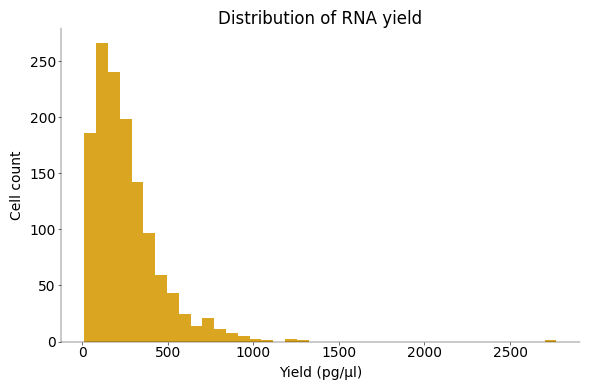

Cells with very low yield (<1 pg/µl): 0
Number of total count outliers: 22


In [92]:
# qualitiy control based on exclusion criteria

yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")

exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""  # already done
to_exclude = exclude != ""
print("Cells flagged for exclusion by experimenter:", np.sum(to_exclude))

qc_metrics = pd.DataFrame(
    {
        "batch": meta["Sequencing batch"],
        "yield": yields,
        "total_counts": meta["Exon reads"],
        "gene_count": meta["Number of genes detected"],
    }
)

# Boxplot yields by batch
qc_metrics.boxplot(column="yield", by="batch", rot=90)
plt.ylabel("Yield (pg/µl)")
plt.title("RNA yield by sequencing batch")
plt.suptitle("")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(yields[~np.isnan(yields)], bins=40, color="goldenrod")
plt.xlabel("Yield (pg/µl)")
plt.ylabel("Cell count")
plt.title("Distribution of RNA yield")
plt.tight_layout()
plt.show()
print("Cells with very low yield (<1 pg/µl):", np.sum(yields < 1))


total_counts = exonCounts.sum(axis=1)
mean_tc, std_tc = np.mean(total_counts), np.std(total_counts)
outliers = (total_counts < mean_tc - 3 * std_tc) | (
    total_counts > mean_tc + 3 * std_tc
)
print("Number of total count outliers:", np.sum(outliers))

# qc_pass = (
#     #(yields > 1)  # yield threshold (adjust as needed)
#     & (exclude == "")  # not flagged by experimenter
#     & (~outliers)  # not an RNA count outlier
#     # Add more conditions as needed
# )
# print("Cells passing all QC:", np.sum(qc_pass))

We excluded cells based on multiple quality control criteria, including flagged exclusion by experimenters, extremely low RNA yield (<1 pg/µl), and outlier values in total RNA counts. This follows the guidelines and exclusion strategies described in Scala et al. (2021).

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/3266939196.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


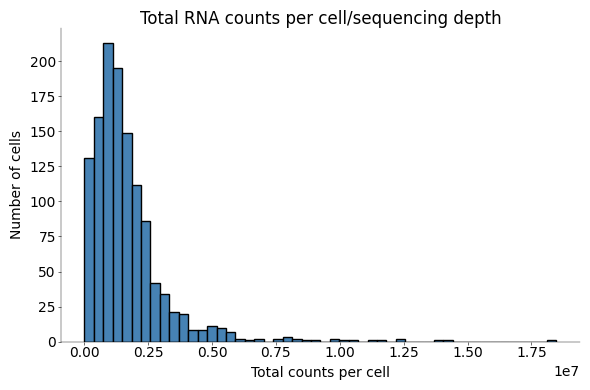

In [93]:
# 1. Total counts per cell
total_counts_per_cell = exonCounts.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(total_counts_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Total counts per cell")
plt.ylabel("Number of cells")
plt.title("Total RNA counts per cell/sequencing depth")
plt.tight_layout()
plt.show()

- Most cells have between about 0.5 million to 3 million counts
- Right-skewed distribution: Long tail towards higher values
- Very high outliers: A handful of cells have extremely high counts (up to ~17 million). These might be doublets (two cells captured together) or could just be very large/active cells

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/961360937.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


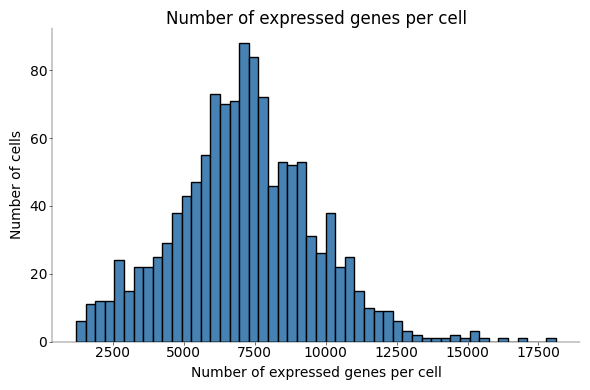

In [94]:
# 2. Number of expressed genes per cell
num_genes_per_cell = (exonCounts > 0).sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(num_genes_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Number of expressed genes per cell")
plt.ylabel("Number of cells")
plt.title("Number of expressed genes per cell")
plt.tight_layout()
plt.show()

- Most cells have 5,000 to 9,000 detected genes
- Distribution shape: This is roughly normal, with some spread to both lower and higher numbers
- Few low outliers: Some cells have as few as ~2,000 expressed genes. These could be lower-quality or rare cell types
- High outliers: Some cells have up to ~17,500 genes detected. These might be doublets or very large cells

- --> No obvious huge population of low-quality cells.
- --> Small tails on both ends—totally normal.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/3384435424.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


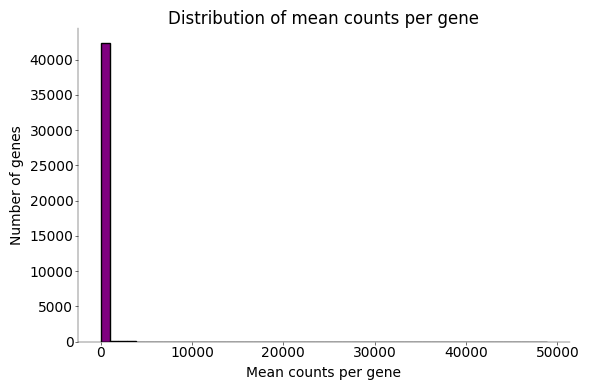

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/3384435424.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


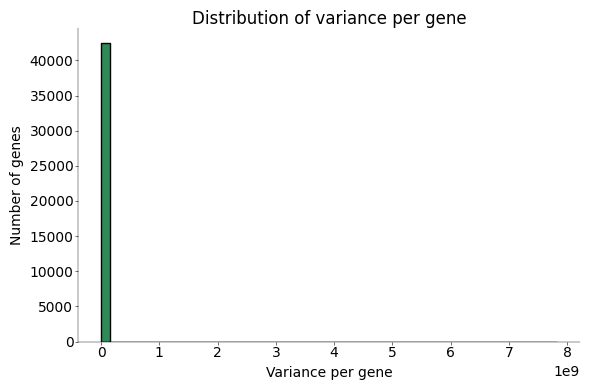

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/3384435424.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


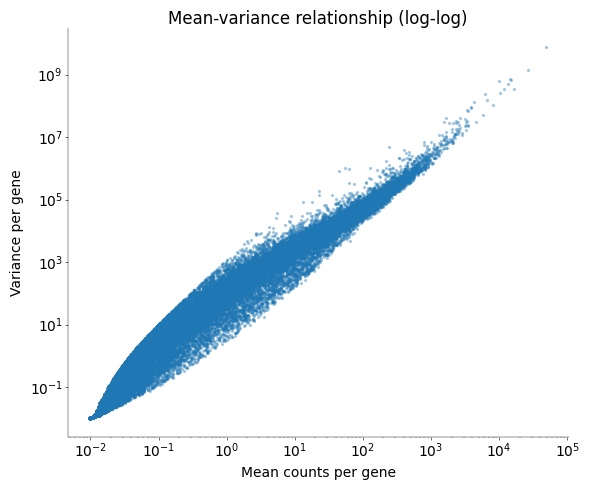

In [95]:
# 3. Mean and variance per gene
mean_counts_per_gene = exonCounts.mean(axis=0)
var_counts_per_gene = exonCounts.var(axis=0)

plt.figure(figsize=(6, 4))
plt.hist(mean_counts_per_gene, bins=50, color="purple", edgecolor="k")
plt.xlabel("Mean counts per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of mean counts per gene")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(var_counts_per_gene, bins=50, color="seagreen", edgecolor="k")
plt.xlabel("Variance per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of variance per gene")
plt.tight_layout()
plt.show()

# 4. Mean-variance relationship (log-log)
plt.figure(figsize=(6, 5))
plt.scatter(
    mean_counts_per_gene + 1e-2, var_counts_per_gene + 1e-2, alpha=0.3, s=8
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean counts per gene")
plt.ylabel("Variance per gene")
plt.title("Mean-variance relationship (log-log)")
plt.tight_layout()
plt.show()

distribution of mean counts per gene
- Huge spike near zero: The vast majority of genes have a very low mean expression across all cells. This is normal—many genes are simply not “on” in most cells, or only expressed in rare cell types
- This is exactly what you expect for scRNA-seq—most genes are off or expressed at low levels, and a minority are expressed at high levels.

distribution of variance per gene
- Most genes have very low variance: This is expected—if a gene is always off, its variance is close to zero
- 

mean variance relationship
- Strong linear relationship on log-log scale: Most points (genes) fall along a line, with variance increasing as the mean increases
- Spread at high mean: At higher mean, some genes have even higher variance—these are likely biologically variable or subject to strong regulation

Most genes have low mean expression and low variance, reflecting the sparse nature of single-cell transcriptomics. A subset of genes show high mean and/or variance, representing genes that are either highly or heterogeneously expressed across cell types. The mean-variance relationship shows a clear positive trend, as expected, with overdispersion typical of read count data.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/4191436859.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


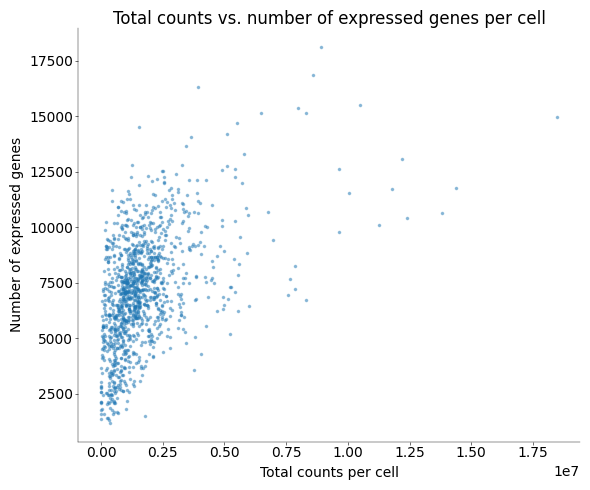

In [96]:
# 5. Scatter: total counts vs. number of expressed genes (per cell)
plt.figure(figsize=(6, 5))
plt.scatter(total_counts_per_cell, num_genes_per_cell, alpha=0.4, s=10)
plt.xlabel("Total counts per cell")
plt.ylabel("Number of expressed genes")
plt.title("Total counts vs. number of expressed genes per cell")
plt.tight_layout()
plt.show()

- Most cells cluster tightly in a main cloud (lower left to mid-right), showing the expected trend: more counts → more genes detected
- few cells are outliers with much higher total counts and/or more detected genes. These are rare, so not a major concern.

In [97]:
marker_genes = ["Pvalb", "Sst", "Vip", "Snap25", "Slc17a7", "Gad2"]
for g in marker_genes:
    if g in genes:
        print(f"{g} found in genes array!")

Pvalb found in genes array!
Sst found in genes array!
Vip found in genes array!
Snap25 found in genes array!
Slc17a7 found in genes array!
Gad2 found in genes array!


In [98]:
# 6. Example: Distribution of counts for a single gene in a single cell type
# Choose a gene and cell type (replace with ones relevant to your data)
# print(genes[:100])  # first 100 genes
# print(np.unique(rna_type))  # See available cell types

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/614777430.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


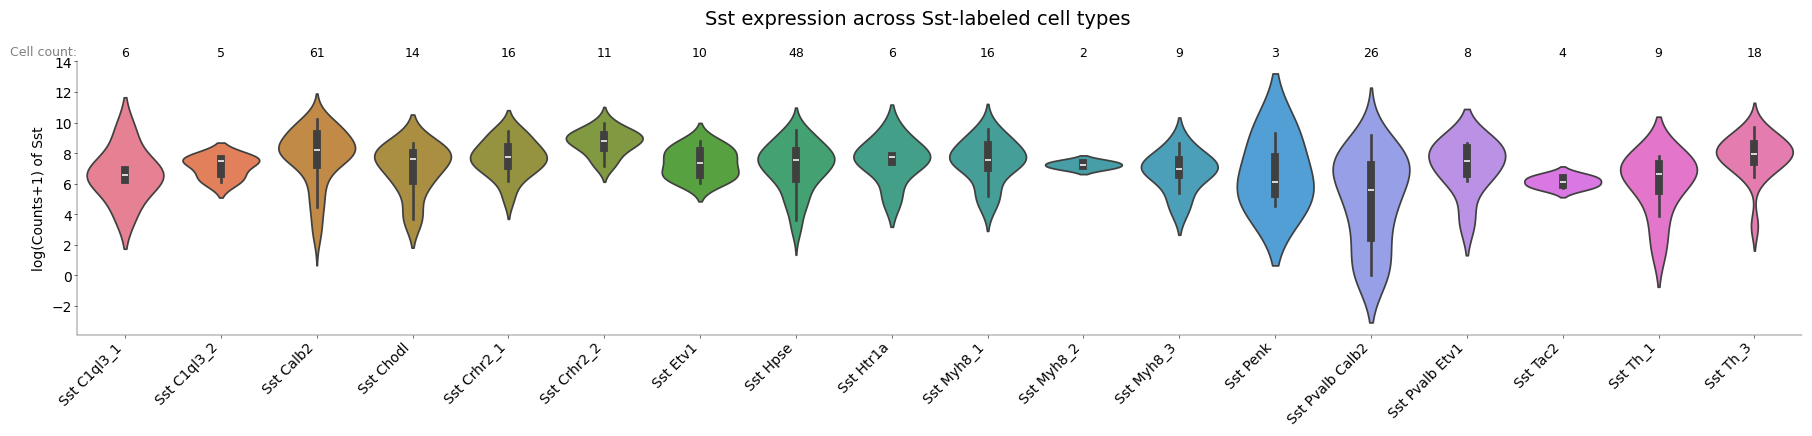

In [99]:
# --------
# 1. Violin/boxplot of a marker gene ('Pvalb') across related cell types
# --------
marker_gene = "Sst"
gene_idx = np.where(genes == marker_gene)[0][0]

related_cell_types = [
    ct for ct in np.unique(rna_type) if ct.startswith(marker_gene)
]

data = []
labels = []
cell_counts = []
for ct in related_cell_types:
    mask = rna_type == ct
    if np.any(mask):
        data.append(np.log1p(exonCounts[mask, gene_idx]))
        labels.append(ct)
        cell_counts.append(np.sum(mask))

plt.figure(figsize=(max(6, len(labels)), 4))
ax = sns.violinplot(data=data, inner="box")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel(f"log(Counts+1) of {marker_gene}")
plt.tight_layout()

# Add cell count annotations above each violin
ymax = plt.ylim()[1]
for i, count in enumerate(cell_counts):
    plt.text(
        i,
        ymax * 1.01,
        str(count),
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# Move 'Cell count:' label far left
plt.text(-1.2, ymax * 1.03, "Cell count:", fontsize=9, color="gray")

# Set the main title *above* the counts
plt.suptitle(
    f"{marker_gene} expression across {marker_gene}-labeled cell types",
    y=1.08,
    fontsize=14,
)

plt.show()

Each “violin” shows the spread of Sst gene expression in cell type
- Wider = more cells with that expression value
- Center line/box = median/interquartile range

- Most violins are centered around log-counts of ~7–10+.
- A few subtypes show a broader or lower distribution: For example, some “Sst Pvalb Calb2” cells have lower Sst expression and/or more spread. This could mean these subtypes are more mixed, or have biological/annotation variability.
- Some subtypes (like “Sst Myh8_2” and “Sst Tac2”) have less spread: Likely fewer cells, or a more homogeneous expression pattern.

Expression of the Sst marker gene is consistently high across all Sst-labeled interneuron subtypes, supporting the validity of the transcriptomic annotations. Some subtypes show broader or more variable Sst expression, reflecting either biological diversity or mixed-type annotations. This confirms that Sst is a robust marker for these interneurons and supports using these labels for validation in downstream analyses.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/4257404159.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


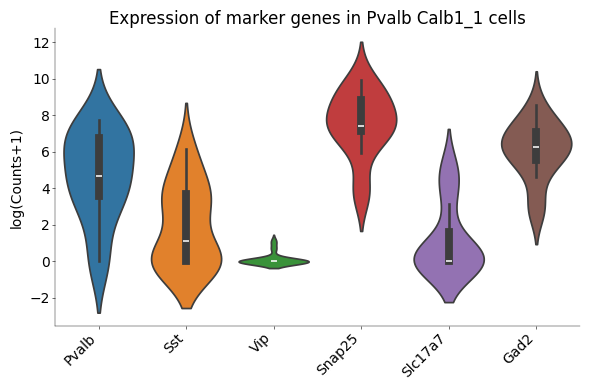

In [100]:
# --------
# 2. Violin/boxplot of multiple marker genes in one cell type
# --------
cell_type = "Pvalb Calb1_1"
genes_to_check = ["Pvalb", "Sst", "Vip", "Snap25", "Slc17a7", "Gad2"]

# Get indices, skipping missing genes
gene_indices = [
    np.where(genes == g)[0][0] for g in genes_to_check if g in genes
]
gene_labels = [g for g in genes_to_check if g in genes]

mask = rna_type == cell_type
data = [np.log1p(exonCounts[mask, idx]) for idx in gene_indices]

plt.figure(figsize=(max(6, len(gene_labels)), 4))
sns.violinplot(data=data, inner="box")
plt.xticks(range(len(gene_labels)), gene_labels, rotation=45, ha="right")
plt.ylabel("log(Counts+1)")
plt.title(f"Expression of marker genes in {cell_type} cells")
plt.tight_layout()
plt.show()

open questions 
- should we normalize for sequencing depth?
- variance stabilizing tarnsformations
- paper from which the data is from: Plots correlations between marker gene expression and electrophysiological features (see their Fig 2/4)—which sets you up for your next project steps!

Show Sst expression is high in Sst subtypes, but low (ideally near zero) in others.

- potentially add “marker-negative” controls --> negative control 
It shows at a glance that your marker gene is not just highly expressed in the marker-positive types (e.g., Sst subtypes), but truly absent (or much lower) in unrelated types (e.g., Pvalb, Vip, Lamp5, excitatory).

Compare Marker Gene Expression Across Major Families
- For each major family (e.g., Sst, Pvalb, Vip, Lamp5, excitatory), plot its marker gene in that family and others.
- Show that expression is family-specific.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


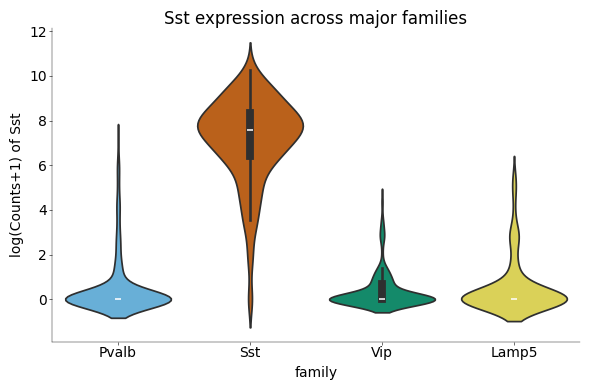

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


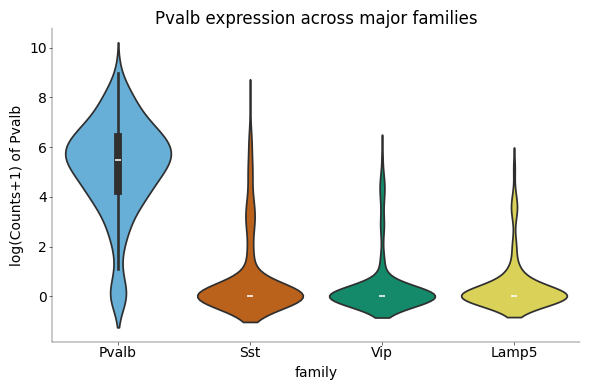

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


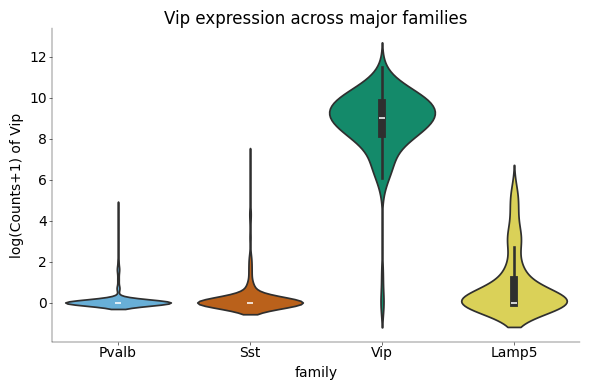

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


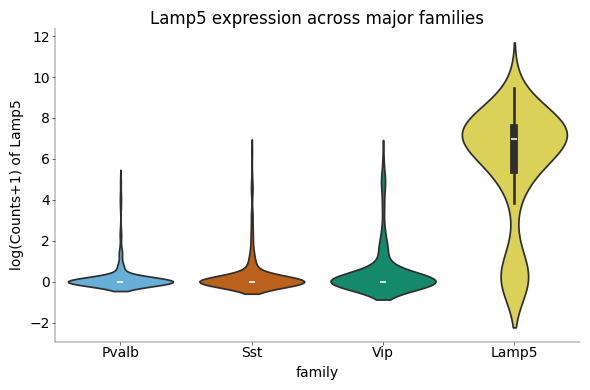

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/2251424583.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


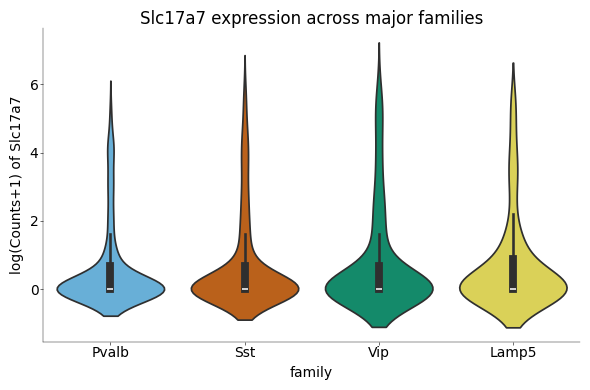

In [101]:
# Extract family from cell_type (first word before space)
families = np.array([ct.split()[0] for ct in rna_type])

marker_genes = [
    "Sst",
    "Pvalb",
    "Vip",
    "Lamp5",
    "Slc17a7",
]  # last one is excitatory neuron marker
family_colors = {
    "Sst": "#56B4E9",
    "Pvalb": "#D55E00",
    "Vip": "#009E73",
    "Lamp5": "#F0E442",
    "Slc17a7": "#0072B2",
}

for marker in marker_genes:
    gene_idx = np.where(genes == marker)[0][0]
    df = pd.DataFrame(
        {"family": families, "log_counts": np.log1p(exonCounts[:, gene_idx])}
    )
    # Only show major families present in your data
    fam_counts = df["family"].value_counts()
    families_to_plot = [fam for fam in marker_genes if fam in fam_counts.index]
    order = families_to_plot

    plt.figure(figsize=(max(6, len(order)), 4))
    sns.violinplot(
        x="family",
        y="log_counts",
        data=df[df["family"].isin(order)],
        palette=[family_colors.get(f, "gray") for f in order],
    )
    plt.ylabel(f"log(Counts+1) of {marker}")
    plt.title(f"{marker} expression across major families")
    plt.tight_layout()
    plt.show()

**Electrophysiological Data**

QC for ephys features:

Removed features that were undefined for many cells, highly redundant, or skewed
Log-transform features with long tails to normalize distributions

In [102]:
print(ephysNames)
# keep only features for filtered ephysData
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]

['AP Fano factor' 'AP amplitude (mV)' 'AP amplitude adaptation index'
 'AP amplitude average adaptation index' 'AP coefficient of variation'
 'AP threshold (mV)' 'AP width (ms)' 'Afterdepolarization (mV)'
 'Afterhyperpolarization (mV)' 'Burstiness' 'ISI Fano factor'
 'ISI adaptation index' 'ISI average adaptation index'
 'ISI coefficient of variation' 'Input resistance (MOhm)' 'Latency (ms)'
 'Latency @ +20pA current (ms)' 'Max number of APs'
 'Membrane time constant (ms)' 'Rebound (mV)' 'Rebound number of APs'
 'Resting membrane potential (mV)' 'Rheobase (pA)' 'Sag area (mV*s)'
 'Sag ratio' 'Sag time (s)' 'Spike frequency adaptation'
 'Upstroke-to-downstroke ratio' 'Wildness']


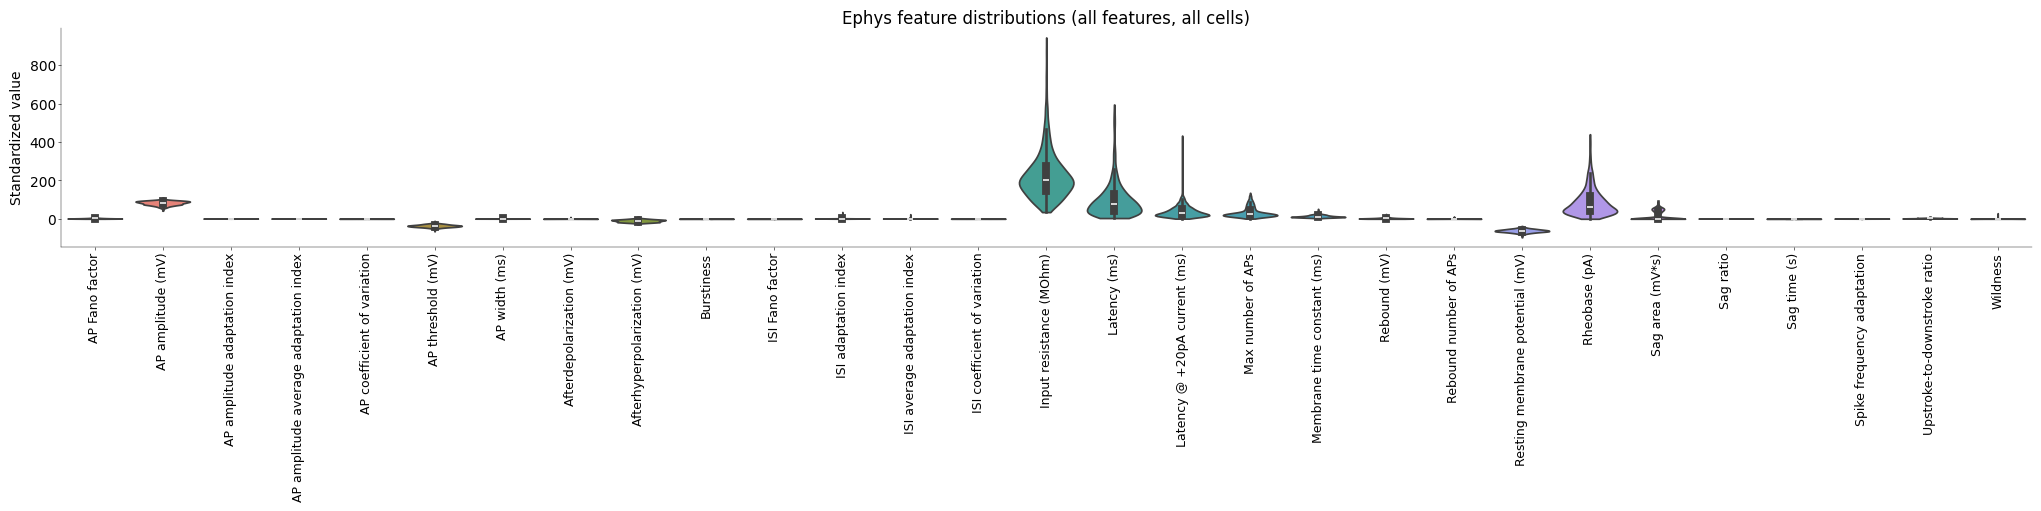

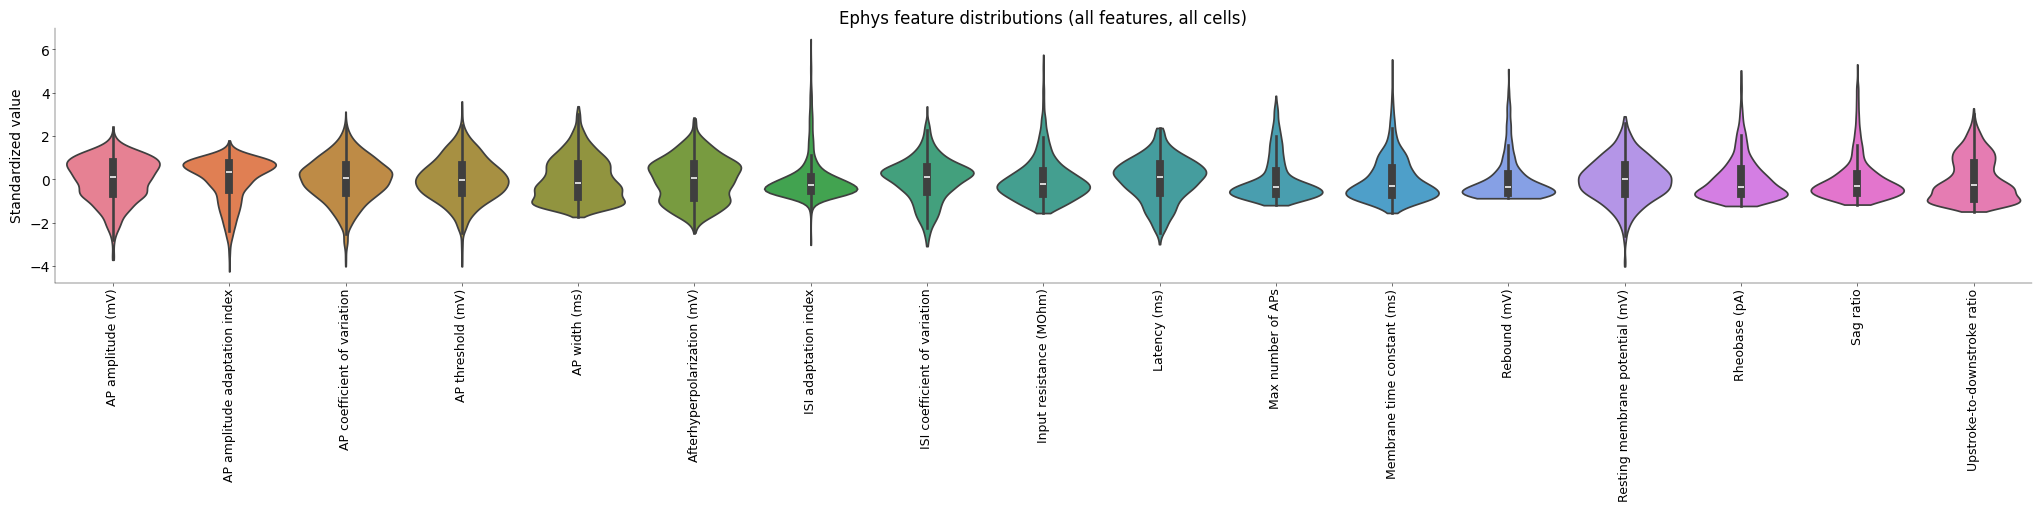

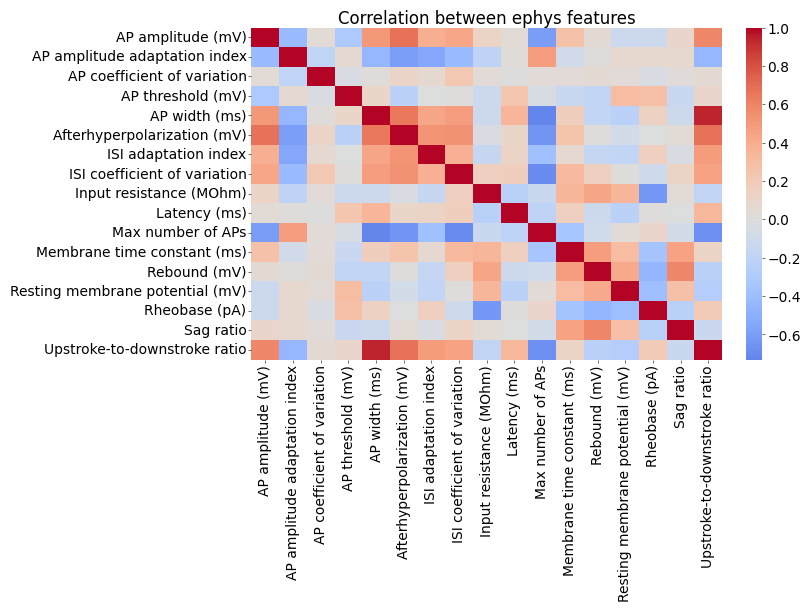

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/433768263.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


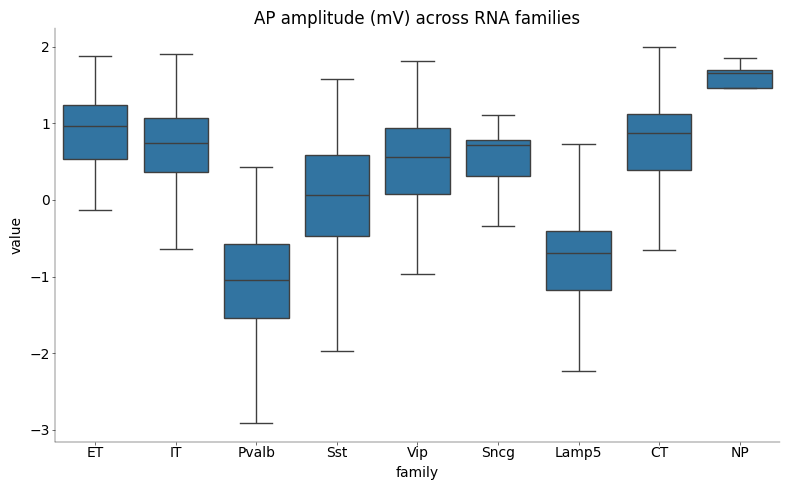

In [103]:
# unfiltered, not normalized data
plt.figure(figsize=(max(10, len(ephysNames) * 0.7), 5))
sns.violinplot(data=pd.DataFrame(ephysData, columns=ephysNames), cut=0)
plt.xticks(rotation=90, fontsize=9)
plt.ylabel("Standardized value")
plt.title("Ephys feature distributions (all features, all cells)")
plt.show()

# normalized and filtered data
plt.figure(figsize=(max(10, len(ephysNames) * 0.7), 5))
sns.violinplot(
    data=pd.DataFrame(ephysData_filtered, columns=ephysNames_filtered), cut=0
)
plt.xticks(rotation=90, fontsize=9)
plt.ylabel("Standardized value")
plt.title("Ephys feature distributions (all features, all cells)")
plt.show()

# corrletaions between features
corr_matrix = np.corrcoef(ephysData_filtered, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    xticklabels=ephysNames_filtered,
    yticklabels=ephysNames_filtered,
    cmap="coolwarm",
    center=0,
)
plt.title("Correlation between ephys features")
plt.show()

# look at specific features across rna families
key_feature = "AP amplitude (mV)"
if key_feature in ephysNames_filtered:
    idx = np.where(ephysNames_filtered == key_feature)[0][0]
    data = pd.DataFrame(
        {
            "value": ephysData_filtered[:, idx],
            "family": np.array(rna_family)[keepcells],
        }
    )
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="family", y="value", data=data, showfliers=False)
    plt.title(f"{key_feature} across RNA families")
    plt.tight_layout()
    plt.show()

**Distribution of values per feature (boxplot or violinplot)**
The Boxplot of standardized electrophysiological features across all cells shows that all features are normalized (median ≈ 0, SD ≈ 1) and display a quite normal spread of values. The  outliers in several features (like “ISI adaptation index”, “Max number of APs”, “Rheobase (pA)”) hints at the diversity/properties among neuron types (and states). No features are constant or missing. This shows the quality and variability of the ephys data for downstream analysis and also cell type comparisons. It also helps to identify features we can focus on in the downstream analysis.

**Correlations between features**
“The feature-feature correlation heatmap shows that several electrophysiological properties are interrelated (e.g., AP shape features), but most features provide largely independent information. These results support the use of this feature set for clustering and cell-type discrimination, and suggest minimal redundancy among key properties.”
avoid redundancy (groups of strongly related features)
"independent features" --> interesing for clustering

For clustering/PCA:
- Consider using only one feature from each strongly correlated pair


For interpretability:
- Keep the most biologically meaningful (e.g., AP width, input resistance)
- Discuss observed feature modules as reflecting known physiological relationships between neuronal excitability and AP shape


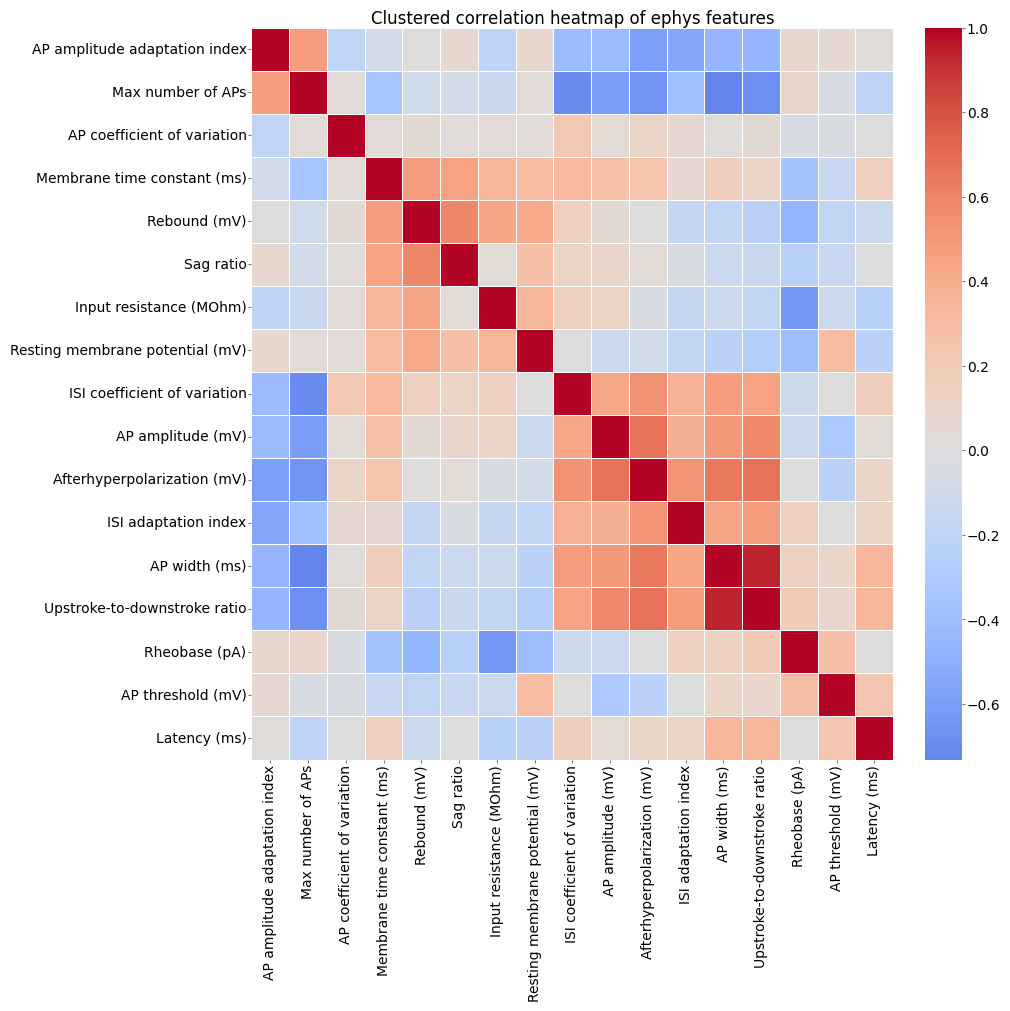

In [104]:
df_ephys = pd.DataFrame(ephysData_filtered, columns=ephysNames_filtered)

from scipy.cluster.hierarchy import linkage, leaves_list

# Compute correlation matrix
corr_matrix = df_ephys.corr()

# Cluster feature order
link = linkage(corr_matrix, method="average")
order = leaves_list(link)

ordered_corr = corr_matrix.values[order][:, order]
ordered_labels = corr_matrix.columns[order]

plt.figure(figsize=(10, 10))
sns.heatmap(
    ordered_corr,
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
)
plt.title("Clustered correlation heatmap of ephys features")
plt.show()

Afterhyperpolarization (AHP) (mV) shows strong positive correlation with:
- Upstroke-to-downstroke ratio (r ≈ +0.67)
- AP amplitude (mV) (r ≈ +0.67)
- AP width (ms) (r ≈ +0.65)
- These all relate to the shape and size of the action potential and afterpotential.

Afterhyperpolarization (AHP) (mV) shows strong negative correlation with:
Input resistance (MOhm) & Rheobase (pA) (r ≈ -0.63): Cells with high input resistance require less current to fire (lower rheobase).

In [105]:
# Get correlation matrix as DataFrame
corr_df = corr_matrix.copy()

# Stack into long-form for easy filtering, remove self-correlations
corr_pairs = (
    corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Only show strong correlations (adjust threshold as needed)
threshold = 0.5
strong_corr = corr_pairs[
    np.abs(corr_pairs["Correlation"]) > threshold
].sort_values(by="Correlation", key=np.abs, ascending=False)

print("Strongly correlated feature pairs (|r| > 0.5):")
print(strong_corr.to_string(index=False))

Strongly correlated feature pairs (|r| > 0.5):
                    Feature 1                    Feature 2  Correlation
                AP width (ms) Upstroke-to-downstroke ratio     0.937448
                AP width (ms)            Max number of APs    -0.731293
 ISI coefficient of variation            Max number of APs    -0.697156
            Max number of APs Upstroke-to-downstroke ratio    -0.680011
  Afterhyperpolarization (mV) Upstroke-to-downstroke ratio     0.669955
            AP amplitude (mV)  Afterhyperpolarization (mV)     0.668830
                AP width (ms)  Afterhyperpolarization (mV)     0.650019
  Afterhyperpolarization (mV)            Max number of APs    -0.648270
      Input resistance (MOhm)                Rheobase (pA)    -0.633236
            AP amplitude (mV)            Max number of APs    -0.600405
AP amplitude adaptation index  Afterhyperpolarization (mV)    -0.594769
                 Rebound (mV)                    Sag ratio     0.594195
            AP am

AP width (ms) & Upstroke-to-downstroke ratio (r ≈ +0.94):
Very strong positive correlation: These two are almost perfectly aligned. They likely describe very similar aspects of action potential shape.
Thus we can safely drop one in clustering/PCA without losing much information.


AP width (ms) & Max number of APs (r ≈ -0.73):
Strong negative correlation: Cells with broader action potentials tend to fire fewer spikes, which suggests biophysical tradeoff (fast-spiking cells = narrow APs and can fire more).


ISI coefficient of variation & Max number of APs (r ≈ -0.70):
ISI CoV (irregularity in spike timing) is high in cells that fire fewer APs.


Max number of APs & Upstroke-to-downstroke ratio (r ≈ -0.68):
More APs = lower upstroke-to-downstroke ratio (again, action potential shape/firing phenotype coupling).

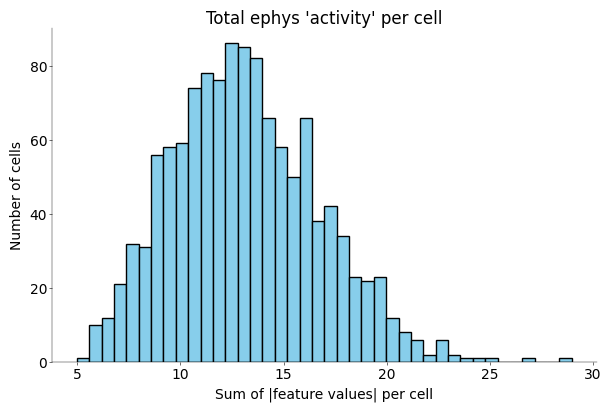

In [106]:
# total "activity" per cell (sum of absolute values)
cell_activity = np.sum(np.abs(ephysData_filtered), axis=1)

plt.figure(figsize=(6, 4))
plt.hist(cell_activity, bins=40, color="skyblue", edgecolor="k")
plt.xlabel("Sum of |feature values| per cell")
plt.ylabel("Number of cells")
plt.title("Total ephys 'activity' per cell")
plt.show()
# Outliers in this plot might be rare weird cells (very high/low ephys overall).

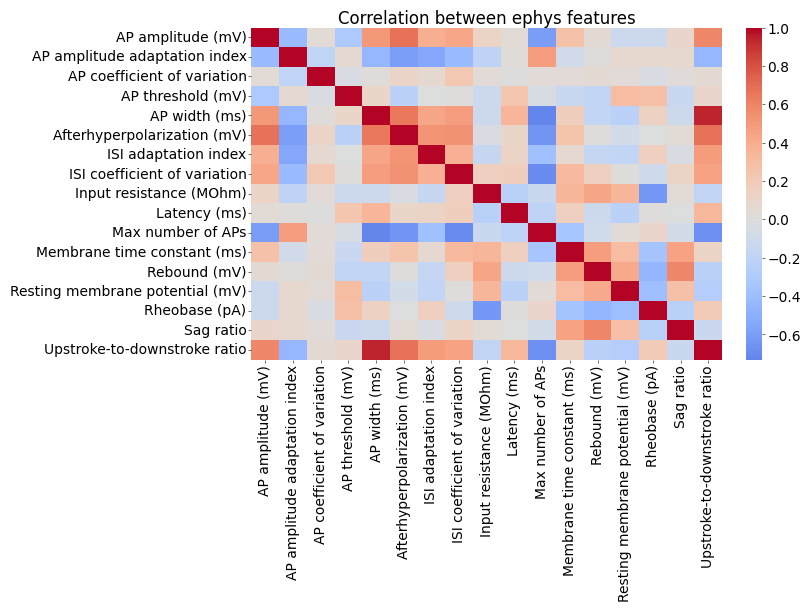

In [107]:
# 4. Feature-feature correlation matrix

corr_matrix = np.corrcoef(ephysData_filtered, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    xticklabels=ephysNames_filtered,
    yticklabels=ephysNames_filtered,
    cmap="coolwarm",
    center=0,
)
plt.title("Correlation between ephys features")
plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/3835694767.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


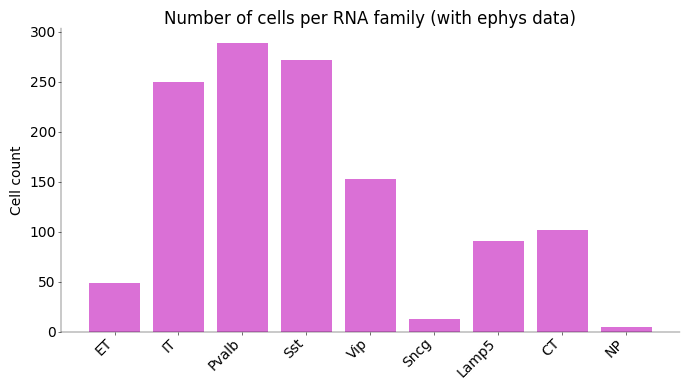

In [108]:
from collections import Counter

# Only include cells with ephys data that passed previous filters
# Assume you already matched ephysData_filtered rows to rna_type/rna_family
valid_types = np.array(rna_type)[
    keepcells
]  # re-use keepcells from earlier filtering
valid_families = np.array(rna_family)[keepcells]

# Barplot: number of cells per RNA family
family_counts = Counter(valid_families)
plt.figure(figsize=(7, 4))
plt.bar(family_counts.keys(), family_counts.values(), color="orchid")
plt.xticks(rotation=45, ha="right")
plt.title("Number of cells per RNA family (with ephys data)")
plt.ylabel("Cell count")
plt.tight_layout()
plt.show()

**meta data usage**
Chato:


For external validation and biological interpretation, we make use of transcriptomic cell type annotations (RNA type/family), Cre line, and anatomical metadata (soma depth, layer). These allowed us to check for concordance between clustering results and known cell identities, confirm the anatomical consistency of layer-restricted t-types, and check for technical artifacts. Following Scala et al. (2021), we used these metadata both for quality control (removing low-confidence or low-yield cells) and for biological insight (comparing the distribution of cell types across Cre lines and anatomical layers).

- Mouse-level info (age, genotype, gender) --> Most cells are adult, and Scala et al. found no strong effect of age/gender for major results
- Soma depth and cortical layer --> Important for mapping cell identity (e.g., some t-types are layer-specific); in Paper: Used to confirm cell type assignments and anatomical localization (Fig. 1b, 4d); How to use: Plot normalized soma depth per RNA type/family (violinplot, boxplot). Use as “external validation”: Do known L2/3 types localize to L2/3?
Overlay on t-SNE/UMAP plots.

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

For our data (read counts, not UMI), standard options for normalization are:

- CPM (Counts Per Million): Each cell's counts are scaled so their sum is 1 million. CPM is biased in some applications where the gene length influences gene expression, such as RNA-seq. Since CPM does not consider gene length when normalizing, it is a suitable gene expression unit for sequencing protocols that generate reads regardless of gene length
- CPMedian: Like CPM, but divide by the median total counts rather than the sum.
- RPKM: CPM, but also divide by gene length in kilobases. RPKM is most useful for comparing gene expression values within a sample, and it is not recommended for performing differential gene expression analysis (sample-to-sample comparisons). The average RPKM values can vary from sample to sample. Generally, the higher the RPKM of a gene, the higher the expression of that gene. RPKM considers the gene length for normalization
- Log-transform: After scaling, apply log1p (log(x+1)), often makes distributions more normal-like.

- RPKM/FPKM/TPM have major limitations for cross-sample comparison; These methods were designed for within-sample normalization (comparing genes within a sample, not between samples). If some genes are highly expressed in a sample, these methods “dilute” the other genes, causing artificial differences between samples. 

- Methods like DESeq2 (median-of-ratios) or TMM (Trimmed Mean of M-values, as in edgeR) are specifically designed for between-sample normalization

chato
- Following recommendations from Zhao et al. (2021) and best practices in the field, we used normalized count data (via the DESeq2 or TMM approach) as the basis for all cross-cell and cross-sample analyses. This avoids the known biases and distortions associated with TPM/FPKM/RPKM normalization, especially in data sets where library composition varies or a few genes dominate expression. For visualization and clustering, we applied a log-transformation to normalized counts and focused on highly variable genes.

In [109]:
# cpm normalization
# exonCounts: (cells, genes) matrix
counts_per_cell = exonCounts.sum(
    axis=1, keepdims=True
)  # this we already calculated above
cpm = exonCounts / counts_per_cell * 1e6  # CPM matrix

# transformations
log_cpm = np.log1p(cpm)

as in CodingLab7 we select highly variable genes based on their fano factor

In [110]:
gene_means = log_cpm.mean(axis=0)
gene_vars = log_cpm.var(axis=0)
gene_dispersion = gene_vars / (gene_means + 1e-6)

# Rank and select top N
N_HVG = 2000  # or 1000, etc.
top_hvg_indices = np.argsort(gene_dispersion)[-N_HVG:]
hvg_genes = genes[top_hvg_indices]

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/807476506.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


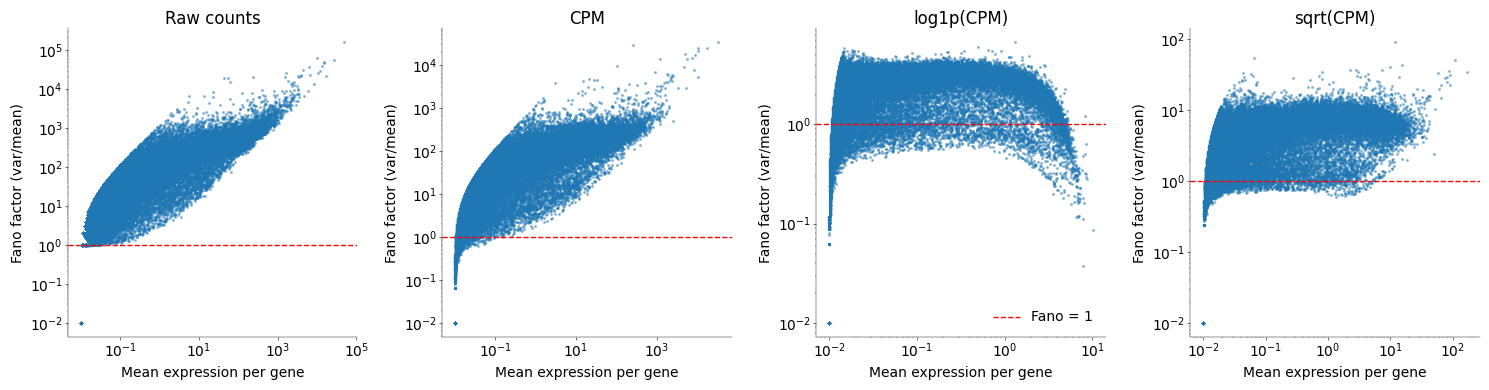

In [111]:
# Compute means and Fano factors for each normalization
# a) Raw counts
mean_raw = exonCounts.mean(axis=0)
var_raw = exonCounts.var(axis=0)
fano_raw = var_raw / (mean_raw + 1e-10)

# b) CPM
counts_per_cell = exonCounts.sum(axis=1, keepdims=True)
cpm = exonCounts / counts_per_cell * 1e6
mean_cpm = cpm.mean(axis=0)
var_cpm = cpm.var(axis=0)
fano_cpm = var_cpm / (mean_cpm + 1e-10)

# c) Log1p(CPM)
log_cpm = np.log1p(cpm)
mean_logcpm = log_cpm.mean(axis=0)
var_logcpm = log_cpm.var(axis=0)
fano_logcpm = var_logcpm / (mean_logcpm + 1e-10)

# d)
sqrt_cpm = np.sqrt(cpm)
mean_sqrtcpm = sqrt_cpm.mean(axis=0)
var_sqrtcpm = sqrt_cpm.var(axis=0)
fano_sqrtcpm = var_sqrtcpm / (mean_sqrtcpm + 1e-10)

plt.figure(figsize=(15, 4))
for i, (mean, fano, title) in enumerate(
    [
        (mean_raw, fano_raw, "Raw counts"),
        (mean_cpm, fano_cpm, "CPM"),
        (mean_logcpm, fano_logcpm, "log1p(CPM)"),
        (mean_sqrtcpm, fano_sqrtcpm, "sqrt(CPM)"),
    ]
):
    plt.subplot(1, 4, i + 1)
    plt.scatter(mean + 1e-2, fano + 1e-2, s=6, alpha=0.4)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Mean expression per gene")
    plt.ylabel("Fano factor (var/mean)")
    plt.title(title)
    plt.axhline(1, color="red", linestyle="--", linewidth=1, label="Fano = 1")
    if i == 2:
        plt.legend()
plt.tight_layout()
plt.show()

raw counts:
- Fano factor > 1 (overdispersion): This is expected for RNA-seq data (especially non-UMI, read-count data) due to technical noise, biological variability, and sampling noise.
- As mean increases, Fano increases much more rapidly (variance grows more than linearly with mean)
cpm:
- Very similar to raw counts: Fano factor > 1 for nearly all genes. Overdispersion and strong mean–variance dependency persist. Slightly more compressed:
CPM removes differences due to sequencing depth, but not variance structure.
log1p(cpm):
- Fano factors are more uniformly distributed, “flattened” across the x-axis (mean). Still some overdispersion for the highest-expressed genes, but overall much less mean–variance relationship. No longer  a dramatic “fan” of points at high mean: The log transform has stabilized variance, making the data much more suitable for PCA, clustering, etc
sqrt(cpm):
- Variance stabilization is improved vs. raw/CPM but not as strong as log1p(CPM). The mean-variance dependence is reduced, but you can still see some upward drift at high means
- sqrt(CPM) is a classic transform for Poisson data, but in practice, log1p(CPM) works better for real single-cell RNA-seq because the data is overdispersed (not purely Poisson)



we therefore will continue using the log1p(cpm) data

chato:
We compared several normalization and variance-stabilizing transformations (raw counts, CPM, log1p(CPM), and sqrt(CPM)) by plotting the mean-variance relationship across genes. Both raw counts and CPM showed strong overdispersion, with the Fano factor increasing rapidly with mean expression. The sqrt transformation partially reduced this effect, but the log1p(CPM) transform most effectively flattened the mean–variance relationship, justifying its use for highly variable gene selection and downstream dimensionality reduction. This matches the approach taken by Scala et al. (2021) and current best practices in single-cell RNA-seq analysis.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_62084/1679365133.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


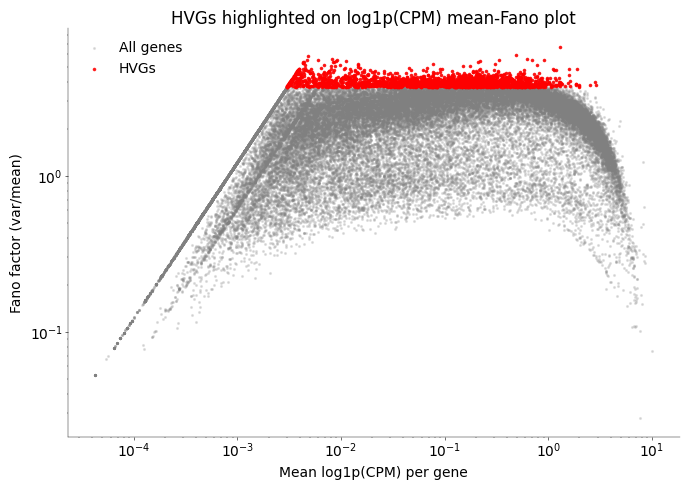

In [112]:
plt.figure(figsize=(7, 5))
plt.scatter(
    mean_logcpm, fano_logcpm, s=6, alpha=0.2, color="gray", label="All genes"
)
plt.scatter(
    mean_logcpm[top_hvg_indices],
    fano_logcpm[top_hvg_indices],
    s=10,
    alpha=0.8,
    color="red",
    label="HVGs",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean log1p(CPM) per gene")
plt.ylabel("Fano factor (var/mean)")
plt.title("HVGs highlighted on log1p(CPM) mean-Fano plot")
plt.legend()
plt.tight_layout()
plt.show()

pca; two fifferent approaches 

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/a

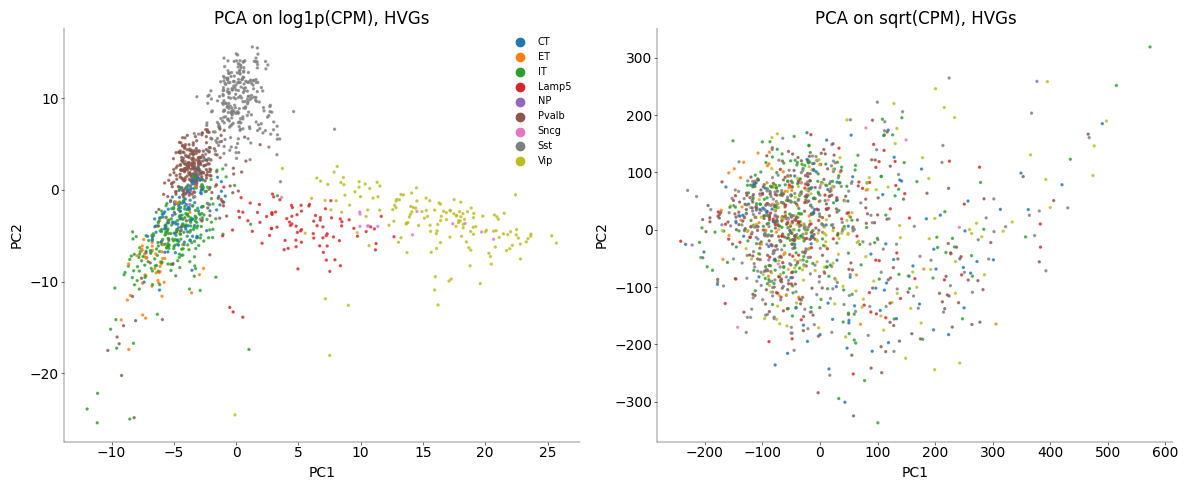

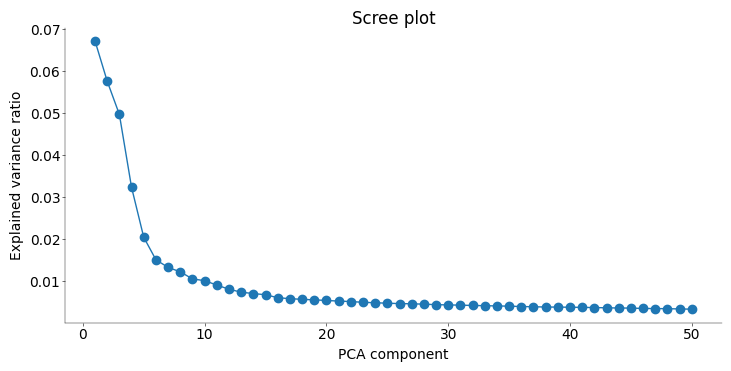

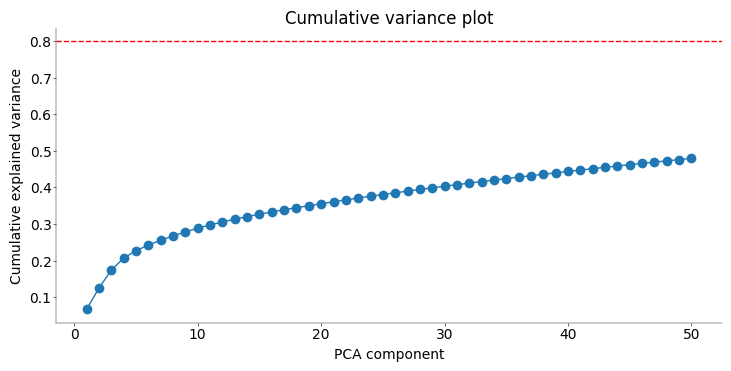

In [122]:
# 1 approach
from sklearn.decomposition import PCA

N_HVG = 1000  # Try with 500, 1000, 2000, etc.

# For log1p(CPM)
gene_disp_log = var_logcpm / (mean_logcpm + 1e-10)
top_idx_log = np.argsort(gene_disp_log)[-N_HVG:]
logcpm_hvg = log_cpm[:, top_idx_log]

# For sqrt(CPM)
gene_disp_sqrt = var_sqrtcpm / (mean_sqrtcpm + 1e-10)
top_idx_sqrt = np.argsort(gene_disp_sqrt)[-N_HVG:]
sqrtcpm_hvg = sqrt_cpm[:, top_idx_sqrt]

n_pcs = 50
pca_log = PCA(n_components=n_pcs)
pca_sqrt = PCA(n_components=n_pcs)
X_pca_log = pca_log.fit_transform(logcpm_hvg)
X_pca_sqrt = pca_sqrt.fit_transform(sqrtcpm_hvg)

# Make your color map for clusters (e.g. RNA family or RNA type)
color_labels = rna_family  # or rna_type, but may be too many for type!
unique_labels = np.unique(color_labels)
label_to_color = {
    lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)
}
cell_colors = [label_to_color[lab] for lab in color_labels]

plt.figure(figsize=(12, 5))

# log1p(CPM) PCA
plt.subplot(1, 2, 1)
plt.scatter(X_pca_log[:, 0], X_pca_log[:, 1], c=cell_colors, s=8, alpha=0.7)
plt.title("PCA on log1p(CPM), HVGs")
plt.xlabel("PC1")
plt.ylabel("PC2")
for lab in unique_labels:
    idx = np.where(color_labels == lab)[0][0]
    plt.scatter([], [], color=label_to_color[lab], label=lab)
plt.legend(markerscale=2, fontsize=7, loc="best")

# sqrt(CPM) PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca_sqrt[:, 0], X_pca_sqrt[:, 1], c=cell_colors, s=8, alpha=0.7)
plt.title("PCA on sqrt(CPM), HVGs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

plt.plot(
    np.arange(1, len(pca_log.explained_variance_ratio_) + 1),
    pca_log.explained_variance_ratio_,
    "o-",
)
plt.xlabel("PCA component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.show()

cumulative = np.cumsum(pca_log.explained_variance_ratio_)
plt.plot(np.arange(1, len(cumulative) + 1), cumulative, "o-")
plt.xlabel("PCA component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative variance plot")
plt.axhline(0.8, color="red", linestyle="--")
plt.show()

are we correctly marking by rna family? would it make sense to color based on different meta data?

What to look for

Cohesive, well-separated clusters:
- Indicates good preservation of cell type/family structure.
- If RNA families cluster separately, normalization/transformation is effective.

Overlapping or diffuse clusters:
- Transformation or HVG selection may not fully capture biological variance.

Changing N_HVG:
- Too few genes: under-sampling, not enough biological signal.
- Too many: add noise, dilute true structure.

Effect of transformation:
- If log1p(CPM) shows sharper clusters than sqrt(CPM), it’s likely more variance-stabilizing.

Effect of n_pcs:
- More components can capture more subtle structure, but first two PCs should already separate major groups if the method works well.

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/a

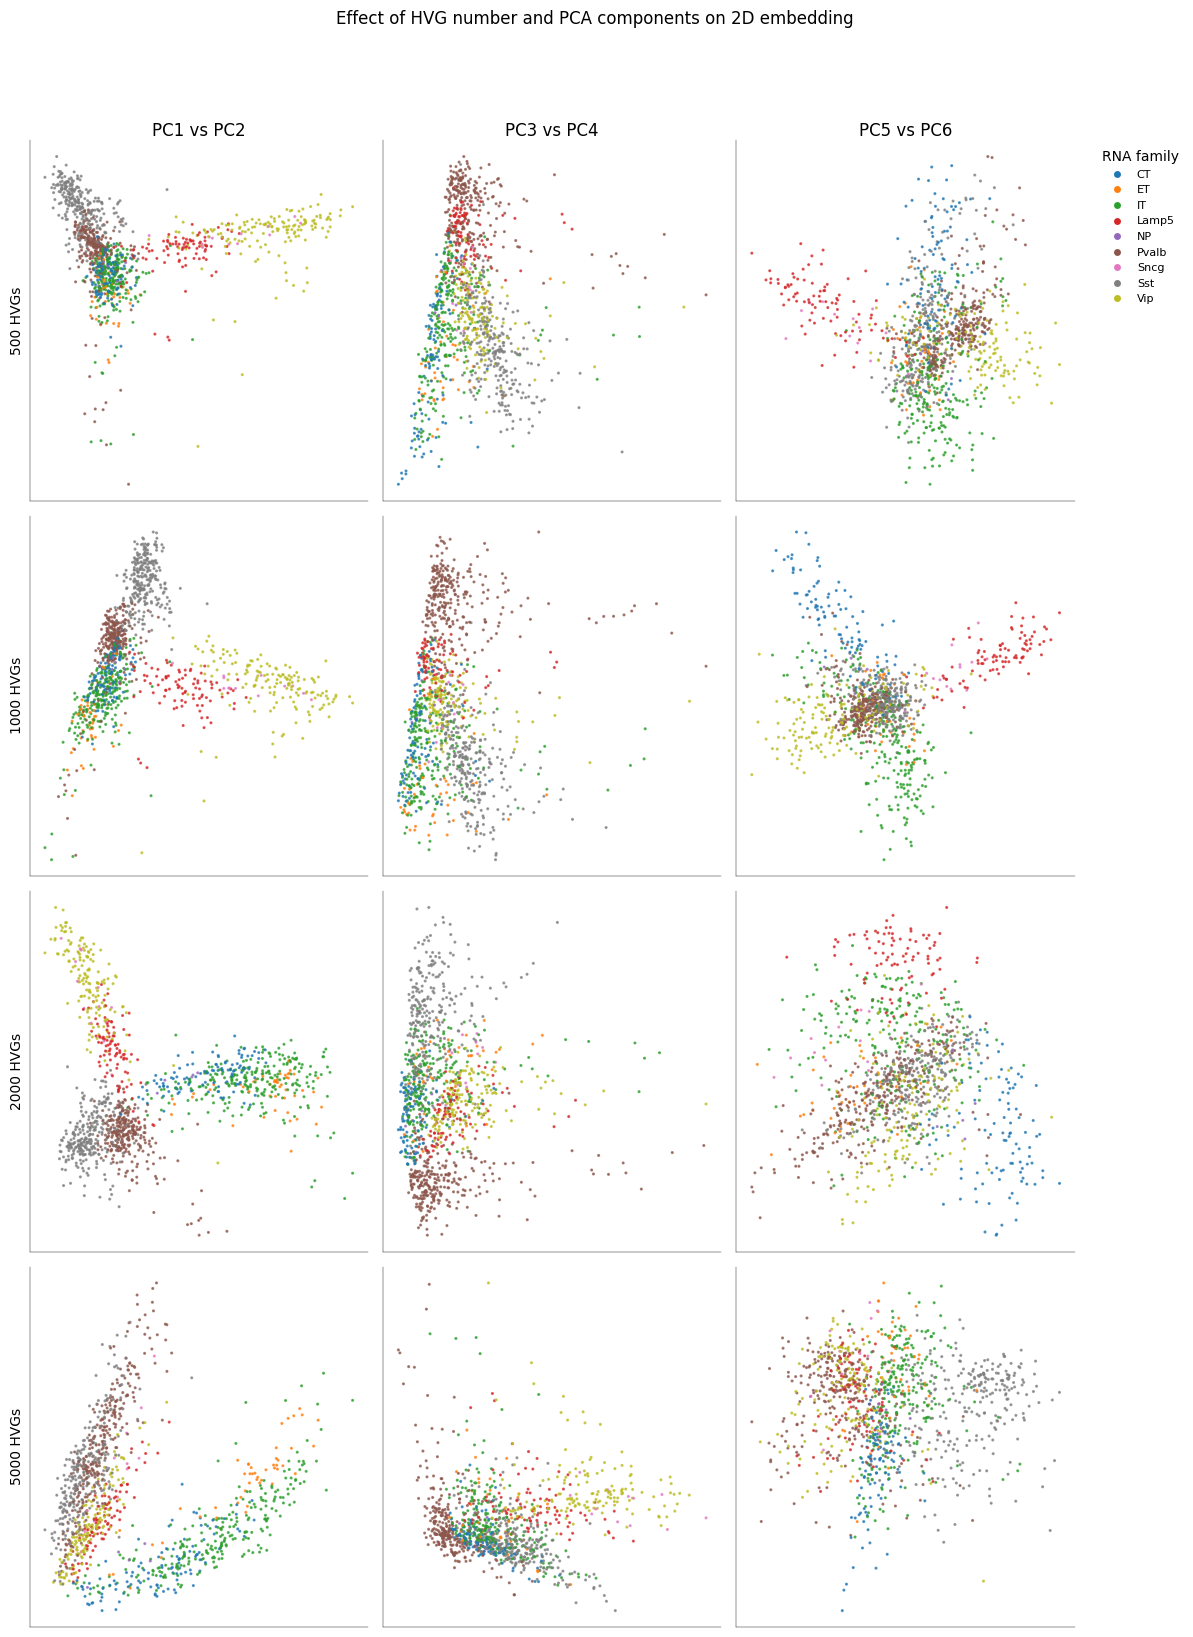

In [114]:
# Parameters to explore
n_hvgs_list = [500, 1000, 2000, 5000]
pc_pairs = [(0, 1), (2, 3), (4, 5)]  # (PC1 vs PC2), (PC3 vs PC4), etc.

# Compute mean/var/fano on log1p(CPM)
gene_means = log_cpm.mean(axis=0)
gene_vars = log_cpm.var(axis=0)
gene_disp = gene_vars / (gene_means + 1e-10)

# Make color labels for families
unique_labels = np.unique(rna_family)
label_to_color = {
    lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)
}
cell_colors = [label_to_color[lab] for lab in rna_family]

fig, axes = plt.subplots(
    len(n_hvgs_list),
    len(pc_pairs),
    figsize=(4 * len(pc_pairs), 4 * len(n_hvgs_list)),
    squeeze=False,
)

for i, n_hvgs in enumerate(n_hvgs_list):
    top_idx = np.argsort(gene_disp)[-n_hvgs:]
    data_hvg = log_cpm[:, top_idx]
    pca = PCA(n_components=max([max(pair) for pair in pc_pairs]) + 1)
    X_pca = pca.fit_transform(data_hvg)
    for j, (pcx, pcy) in enumerate(pc_pairs):
        ax = axes[i, j]
        ax.scatter(X_pca[:, pcx], X_pca[:, pcy], c=cell_colors, s=6, alpha=0.7)
        if i == 0:
            ax.set_title(f"PC{pcx+1} vs PC{pcy+1}")
        if j == 0:
            ax.set_ylabel(f"{n_hvgs} HVGs")
        ax.set_xticks([])
        ax.set_yticks([])

# Optional: Add a legend
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=lab,
        markerfacecolor=label_to_color[lab],
        markersize=6,
    )
    for lab in unique_labels
]
axes[0, -1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8,
    title="RNA family",
)

plt.suptitle("Effect of HVG number and PCA components on 2D embedding", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

which kind of distribution should our counts follow?


look at codinglab7 for interpreration of overdispersion (in which plots can it be observed, what can we do about it)


what number of compoenst is the default for clustering?

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

In [123]:
# Compute dispersion for log1p(CPM)
gene_means = log_cpm.mean(axis=0)
gene_vars = log_cpm.var(axis=0)
gene_disp = gene_vars / (gene_means + 1e-10)

N_HVG = 2000  # or adjust as you like
top_idx = np.argsort(gene_disp)[-N_HVG:]
X_hvg = log_cpm[:, top_idx]

In [ ]:
from sklearn.manifold import TSNE
import umap

# PCA
n_pcs = 50
pca = PCA(n_components=n_pcs)
X_pca_full = pca.fit_transform(X_hvg)
X_pca_2d = X_pca_full[:, :2]

# t-SNE (on first 50 PCs for speed/stability)
X_tsne = TSNE(
    n_components=2, perplexity=30, n_iter=1000, random_state=0
).fit_transform(X_pca_full)

# UMAP (on first 50 PCs)
X_umap = umap.UMAP(
    n_neighbors=15, min_dist=0.3, n_components=2, random_state=0
).fit_transform(X_pca_full)

ModuleNotFoundError: No module named 'umap'

NameError: name 'X_pca_2d' is not defined

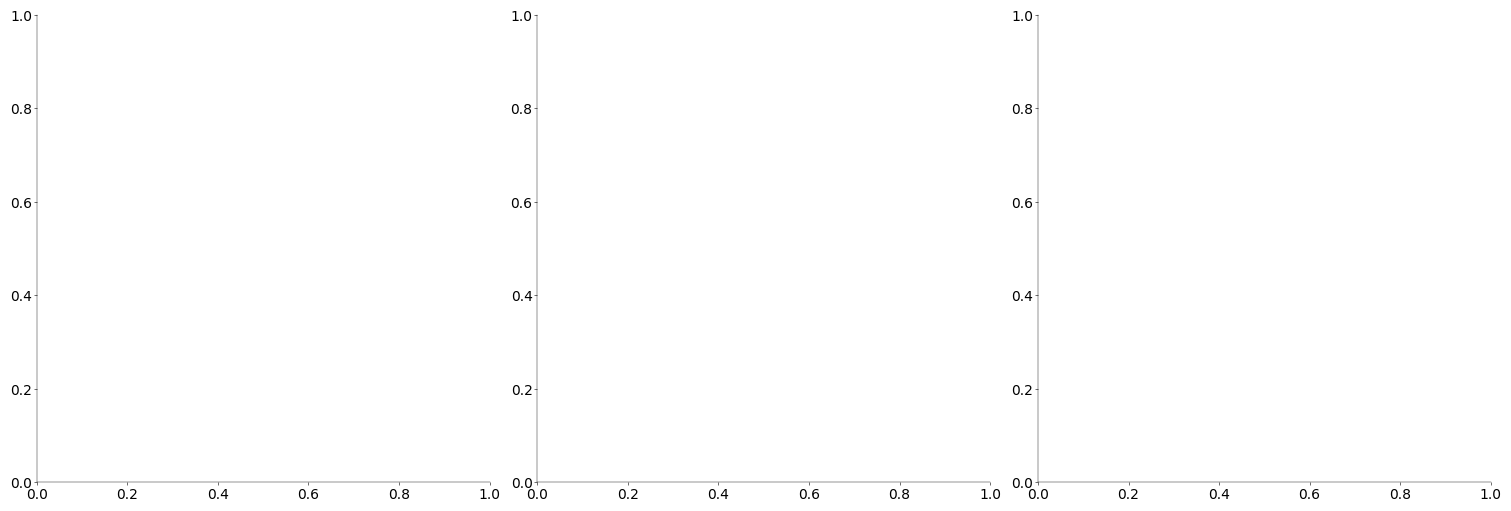

In [ ]:
labels = np.array(rna_family)  # or rna_type for more granularity
unique_labels = np.unique(labels)
color_dict = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}
cell_colors = [color_dict[lab] for lab in labels]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (embedding, title) in enumerate(
    [
        (X_pca_2d, "PCA"),
        (X_tsne, "t-SNE"),
        (X_umap, "UMAP"),
    ]
):
    ax = axes[i]
    sc = ax.scatter(
        embedding[:, 0], embedding[:, 1], c=cell_colors, s=8, alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    for j, lab in enumerate(unique_labels):
        ax.scatter([], [], color=color_dict[lab], label=lab)
    if i == 2:
        ax.legend(
            markerscale=2,
            fontsize=8,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )

plt.suptitle("2D embeddings of single-cell RNA-seq data (top HVGs)", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

def knn_accuracy(embedding, labels, k=10):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    indices = nbrs.kneighbors(return_distance=False)[:,1:]
    acc = np.mean([np.mean(labels[indices[i]] == labels[i]) for i in range(len(labels))])
    return acc

def knn_recall(highdim, embedding, k=10):
    nbrs_high = NearestNeighbors(n_neighbors=k+1).fit(highdim)
    high_idx = nbrs_high.kneighbors(return_distance=False)[:,1:]
    nbrs_emb = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    emb_idx = nbrs_emb.kneighbors(return_distance=False)[:,1:]
    recall = np.mean([len(set(high_idx[i]) & set(emb_idx[i]))/k for i in range(len(highdim))])
    return recall

for name, embedding in zip(
    ['PCA', 't-SNE', 'UMAP'],
    [X_pca_2d, X_tsne, X_umap]
):
    print(f"\n{name} embedding:")
    print(f"  kNN accuracy: {knn_accuracy(embedding, labels, k=10):.3f}")
    print(f"  Silhouette coefficient: {silhouette_score(embedding, labels):.3f}")
    # kNN recall (relative to 50D PCA)
    print(f"  kNN recall: {knn_recall(X_pca_full, embedding, k=10):.3f}")
    # Adjusted Mutual Information: compare k-means clustering (use same number of clusters as unique labels)
    pred = KMeans(n_clusters=len(unique_labels), n_init=10, random_state=0).fit_predict(embedding)
    print(f"  Adjusted Mutual Information (AMI): {adjusted_mutual_info_score(labels, pred):.3f}")


Interpretation:

- kNN accuracy: Higher is better; shows if cells of the same ground truth cluster together.
- Silhouette coefficient: Higher is better; clusters are tight and well-separated.
- kNN recall: Measures how many true high-dimensional neighbors are preserved in 2D; typically lower for t-SNE/UMAP.
- AMI: How well 2D clusters correspond to ground truth labels.

- play with params of algorithms/vary them systematically
- use ephys data or other meat data for coloring

In [ ]:
# Parameter ranges (adjust as desired)
tsne_perplexities = [5, 15, 30, 50]
tsne_exaggerations = [1, 4, 12]  # 1=classic, 4=default, 12=supervises separation
umap_neighbors = [5, 15, 30, 50]
umap_min_dists = [0.01, 0.1, 0.3, 0.5]

# Prepare to store results
results = []

In [ ]:
# t-SNE grid
for perp in tsne_perplexities:
    for exag in tsne_exaggerations:
        tsne = TSNE(n_components=2, perplexity=perp, exaggeration=exag, n_iter=1000, random_state=0)
        X_tsne = tsne.fit_transform(X_pca_full)
        
        knn_acc = knn_accuracy(X_tsne, labels, k=10)
        knn_rec = knn_recall(X_pca_full, X_tsne, k=10)
        sil = silhouette_score(X_tsne, labels)
        pred = KMeans(n_clusters=len(unique_labels), n_init=10, random_state=0).fit_predict(X_tsne)
        ami = adjusted_mutual_info_score(labels, pred)
        
        results.append({
            'method': 't-SNE',
            'perplexity': perp,
            'exaggeration': exag,
            'kNN_acc': knn_acc,
            'kNN_rec': knn_rec,
            'silhouette': sil,
            'AMI': ami
        })
        print(f"t-SNE (perp={perp}, exag={exag}): kNN_acc={knn_acc:.3f}, sil={sil:.3f}, AMI={ami:.3f}, kNN_rec={knn_rec:.3f}")

In [ ]:
# umap grid
import umap

for n_neigh in umap_neighbors:
    for min_dist in umap_min_dists:
        umap_model = umap.UMAP(n_neighbors=n_neigh, min_dist=min_dist, n_components=2, random_state=0)
        X_umap = umap_model.fit_transform(X_pca_full)
        
        knn_acc = knn_accuracy(X_umap, labels, k=10)
        knn_rec = knn_recall(X_pca_full, X_umap, k=10)
        sil = silhouette_score(X_umap, labels)
        pred = KMeans(n_clusters=len(unique_labels), n_init=10, random_state=0).fit_predict(X_umap)
        ami = adjusted_mutual_info_score(labels, pred)
        
        results.append({
            'method': 'UMAP',
            'n_neighbors': n_neigh,
            'min_dist': min_dist,
            'kNN_acc': knn_acc,
            'kNN_rec': knn_rec,
            'silhouette': sil,
            'AMI': ami
        })
        print(f"UMAP (neighbors={n_neigh}, min_dist={min_dist}): kNN_acc={knn_acc:.3f}, sil={sil:.3f}, AMI={ami:.3f}, kNN_rec={knn_rec:.3f}")


In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)

# Example: plot kNN accuracy for t-SNE with different parameters
df_tsne = df_results[df_results['method'] == 't-SNE']
pivot = df_tsne.pivot(index='perplexity', columns='exaggeration', values='kNN_acc')

import seaborn as sns
sns.heatmap(pivot, annot=True, fmt=".2f")
plt.title("t-SNE kNN accuracy")
plt.xlabel("Exaggeration")
plt.ylabel("Perplexity")
plt.show()

# Repeat for UMAP, or for other metrics (e.g., silhouette, AMI)
df_umap = df_results[df_results['method'] == 'UMAP']
pivot_umap = df_umap.pivot(index='n_neighbors', columns='min_dist', values='kNN_acc')
sns.heatmap(pivot_umap, annot=True, fmt=".2f")
plt.title("UMAP kNN accuracy")
plt.xlabel("min_dist")
plt.ylabel("n_neighbors")
plt.show()


chato
- We systematically varied t-SNE (perplexity, exaggeration) and UMAP (n_neighbors, min_dist) parameters and compared the resulting embeddings using quantitative metrics as recommended by Lause et al. (2024). We report kNN accuracy, silhouette coefficient, and adjusted mutual information for each parameter set (see Figure/Table X). Our results show that [summarize: e.g., ‘t-SNE with perplexity 30 and exaggeration 4 maximized kNN accuracy, while UMAP was more robust to parameter choice’].”